__NAME:__ __FULLNAME__  
__SECTION:__ __NUMBER__  
__CS 5970: Machine Learning Practices__

# Homework 9: Decision

## Assignment Overview
Follow the TODOs and read through and understand any provided code. 
Post any questions you might have to the Canvas discussion. 
For all plots, make sure all necessary axes and curves are clearly and 
accurately labeled. Include figure/plot titles appropriately as well.


### Task
For this assignment you will be exploring Decision Tree Classifiers.


### [Data set](https://canvas.ou.edu/courses/163924/files/folder/Homework%20Solutions)

These data were re-configured from a dataset collected for the purpose of detecting Health care Provider Fraud. Total Medicare spending increases exponentially due to frauds in Medicare claims. Healthcare fraud involves health care providers, physicians, patients, and beneficiaries acting intandum to construct fraudulent claims.

The goal is to "predict potentially fraudulent providers" from summary statistics of their filed healthcare claims. 

__Features__  
The features are aggregate statistics computed as either the mean or the sum.
For the following features, the column is indicative of the average value for the provider's claims:  
* InscClaimAmtReimbursed  
* DeductibleAmtPaid
* NoOfMonths_PartACov
* NoOfMonths_PartBCov
* IPAnnualReimbursementAmt
* IPAnnualDeductibleAmt
* OPAnnualReimbursementAmt
* OPAnnualDeductibleAmt
* NumPhysiciansSeen
* NumProcedures
* NumDiagnosisClaims
* Age
 
For the following features, the column is indicative of the total number among the provider's claims:  
* ChronicCond_Alzheimer  
* ChronicCond_Heartfailure  
* ChronicCond_KidneyDisease  
* ChronicCond_Cancer  
* ChronicCond_ObstrPulmonary  
* ChronicCond_Depression  
* ChronicCond_Diabetes  
* ChronicCond_IschemicHeart  
* ChronicCond_Osteoporasis  
* ChronicCond_rheumatoidarthritis  
* ChronicCond_stroke  
* RenalDiseaseIndicator  

These data were amalagmated from the [HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS](https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis) data set on Kaggle.


### Objectives
* Introduction to Decision Trees


### Notes
* Do not save work within the ml_practices folder


### General References
* [Guide to Jupyter](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Numpy Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [DataCamp: Matplotlib](https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=9026223&gclid=CjwKCAjw_uDsBRAMEiwAaFiHa8xhgCsO9wVcuZPGjAyVGTitb_-fxYtkBLkQ4E_GjSCZFVCqYCGkphoCjucQAvD_BwE)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [Sci-kit Learn Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [Sci-kit Learn Preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)


In [1]:
# THESE FIRST 3 IMPORTS ARE FROM FILES IN THE ML_PRACTICES FOLDER UNDER HW9
# Use the versions found in the hw9 folder as some changes were made
import visualize
import metrics_plots
from pipeline_components import DataSampleDropper, DataFrameSelector, DataScaler

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, os, pathlib
import time as timelib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import log_loss, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.externals import joblib
import pickle as pkl

FIGW = 5
FIGH = 5
FONTSIZE = 12

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline
plt.style.use('ggplot')

In [2]:
""" PROVIDED
Display current working directory of this notebook. If you are using 
relative paths for your data, then it needs to be relative to the CWD.
"""
HOME_DIR = pathlib.Path.home()
pathlib.Path.cwd()

PosixPath('/home/jovyan/hws/hw9')

# LOAD DATA

In [3]:
# TODO: set path appropriately. 
# data file can be found on canvas under Files/Homework Solutions and on git
fname = "health_provider_fraud.csv"
claims_data = pd.read_csv(fname)
claims_data.shape

(5410, 25)

In [4]:
""" PROVIDED
Display data info
"""
claims_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 25 columns):
Provider                           5410 non-null object
PotentialFraud                     5410 non-null bool
Age                                5410 non-null float64
NumPhysiciansSeen                  5410 non-null float64
NumProcedures                      5410 non-null float64
NumDiagnosisClaims                 5410 non-null float64
InscClaimAmtReimbursed             5410 non-null float64
DeductibleAmtPaid                  5409 non-null float64
NoOfMonths_PartACov                5410 non-null float64
NoOfMonths_PartBCov                5410 non-null float64
IPAnnualReimbursementAmt           5410 non-null float64
IPAnnualDeductibleAmt              5410 non-null float64
OPAnnualReimbursementAmt           5410 non-null float64
OPAnnualDeductibleAmt              5410 non-null float64
ChronicCond_Alzheimer              5410 non-null int64
ChronicCond_Heartfailure           5410 non-

In [5]:
""" PROVIDED
Display the head of the data
"""
claims_data.head()

,Provider,PotentialFraud,Age,NumPhysiciansSeen,NumProcedures,NumDiagnosisClaims,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,PRV51001,False,78.840000,1.280000,0.120000,3.640000,4185.600000,213.600000,12.000000,12.000000,...,19,17,5,10,9,21,23,6,8,6
1,PRV51003,True,70.022727,1.181818,0.363636,5.765152,4588.409091,502.166667,11.818182,11.871212,...,80,64,10,41,54,100,112,33,38,12
2,PRV51004,False,72.161074,1.322148,0.000000,2.751678,350.134228,2.080537,11.865772,11.959732,...,88,50,16,41,63,105,108,49,46,17
3,PRV51005,True,70.475536,1.209442,0.000000,2.786266,241.124464,3.175966,11.907296,11.939914,...,680,507,165,295,485,799,895,344,331,124
4,PRV51007,False,69.291667,1.125000,0.013889,3.208333,468.194444,45.333333,11.833333,11.833333,...,40,22,12,16,29,49,51,21,22,12


In [6]:
""" PROVIDED
Display the summary statistics
Make sure you skim this
"""
claims_data.describe()

,Age,NumPhysiciansSeen,NumProcedures,NumDiagnosisClaims,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
count,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5409.000000,5410.000000,5410.000000,5410.000000,5410.000000,...,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000
mean,73.731027,1.227410,0.108011,3.676631,1740.679369,155.643175,11.919716,11.930647,6166.692586,666.980865,...,60.921072,42.510906,15.620148,32.288540,44.863956,72.783549,78.341959,32.775231,32.107024,10.495564
std,4.712307,0.220822,0.246305,1.882603,3484.473124,306.489453,0.395682,0.310612,6203.422910,623.108956,...,158.698296,110.048136,41.558020,82.958866,117.563035,190.919202,205.233787,85.862305,84.497824,27.171512
min,34.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71.768368,1.000000,0.000000,2.696134,232.394593,0.312500,11.994207,11.965836,2902.238095,356.000000,...,6.000000,4.000000,1.000000,3.000000,4.000000,7.000000,7.000000,3.000000,3.000000,1.000000
50%,73.863636,1.200000,0.000000,3.000000,356.085106,4.285714,12.000000,12.000000,4729.047927,527.580008,...,18.000000,13.000000,5.000000,10.000000,13.000000,22.000000,23.000000,10.000000,9.000000,3.000000
75%,75.760000,1.375000,0.083333,3.847902,1490.154301,137.418605,12.000000,12.000000,7336.173195,801.000000,...,52.750000,37.000000,13.000000,29.000000,39.000000,62.750000,67.000000,28.000000,28.000000,9.000000
max,101.000000,3.000000,3.000000,11.000000,57000.000000,1068.000000,12.000000,12.000000,103000.000000,12068.000000,...,4638.000000,3111.000000,1238.000000,2312.000000,3592.000000,5784.000000,6074.000000,2531.000000,2511.000000,810.000000


# PRE-PROCESS DATA

In [7]:
""" PROVIDED
Construct preprocessing pipeline
"""
selected_features = claims_data.columns
scaled_features = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
                   'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                   'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

pipe = Pipeline([
    ('RowDropper', DataSampleDropper()),
    ('FeatureSelector', DataFrameSelector(selected_features)),
    ('Scale', DataScaler(scaled_features))
])

In [8]:
""" TODO
Pre-process the data using the defined pipeline
"""
processed_data = # TODO
processed_data.shape

(5409, 25)

In [9]:
""" TODO
Verify all NaNs removed
"""



Provider                           0
PotentialFraud                     0
Age                                0
NumPhysiciansSeen                  0
NumProcedures                      0
NumDiagnosisClaims                 0
InscClaimAmtReimbursed             0
DeductibleAmtPaid                  0
NoOfMonths_PartACov                0
NoOfMonths_PartBCov                0
IPAnnualReimbursementAmt           0
IPAnnualDeductibleAmt              0
OPAnnualReimbursementAmt           0
OPAnnualDeductibleAmt              0
ChronicCond_Alzheimer              0
ChronicCond_Heartfailure           0
ChronicCond_KidneyDisease          0
ChronicCond_Cancer                 0
ChronicCond_ObstrPulmonary         0
ChronicCond_Depression             0
ChronicCond_Diabetes               0
ChronicCond_IschemicHeart          0
ChronicCond_Osteoporasis           0
ChronicCond_rheumatoidarthritis    0
ChronicCond_stroke                 0
dtype: int64

# VISUALIZE DATA

False    0.906452
True     0.093548
Name: PotentialFraud, dtype: float64

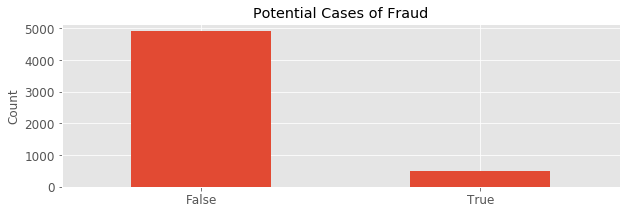

In [10]:
""" PROVIDED
Plot the class distributions for no potential fraud and potential fraud
"""
class_counts = pd.value_counts(processed_data['PotentialFraud'])
class_counts.plot(kind='bar', rot=0, figsize=(10,3))
plt.title("Potential Cases of Fraud")
plt.ylabel("Count")

# Display the class fractions
nsamples, nfeatures = processed_data.shape
class_counts / nsamples

In [11]:
""" PROVIDED
Extract positions of the postive and negative cases
"""
pos = processed_data['PotentialFraud'] == 1
neg = processed_data['PotentialFraud'] == 0

FEATURE: PotentialFraud


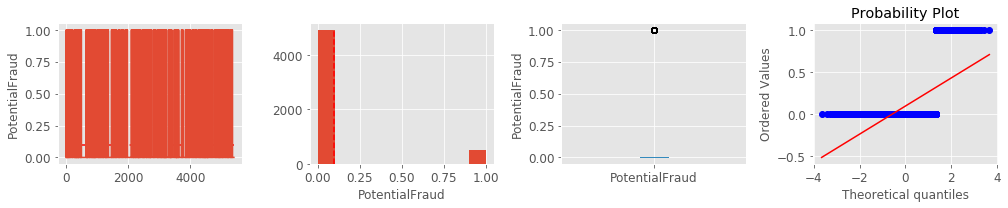

FEATURE: Age


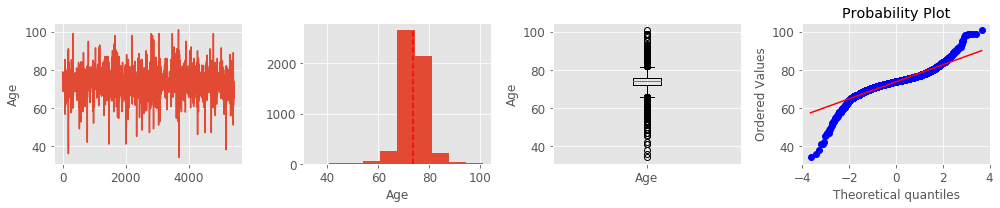

FEATURE: NumPhysiciansSeen


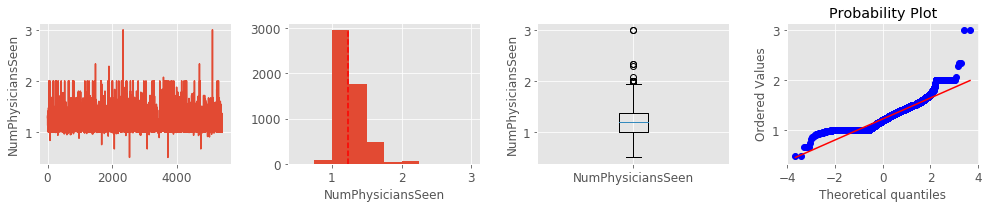

FEATURE: NumProcedures


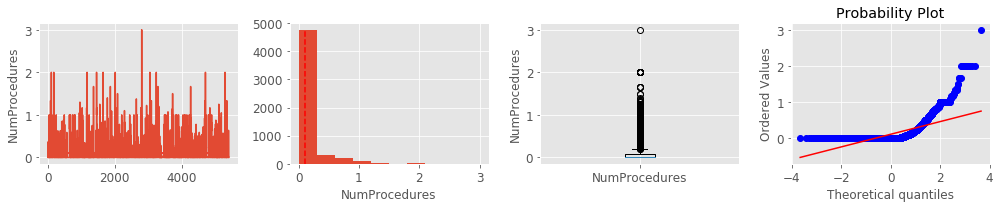

FEATURE: NumDiagnosisClaims


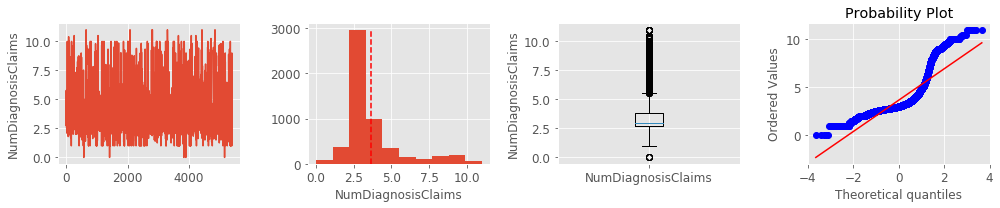

FEATURE: InscClaimAmtReimbursed


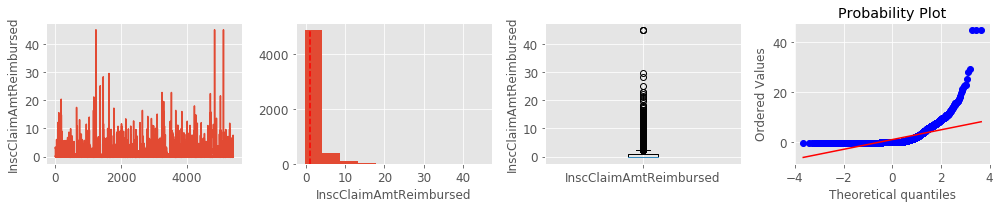

FEATURE: DeductibleAmtPaid


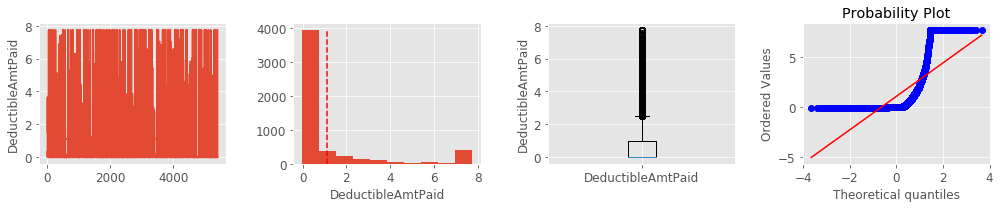

FEATURE: NoOfMonths_PartACov


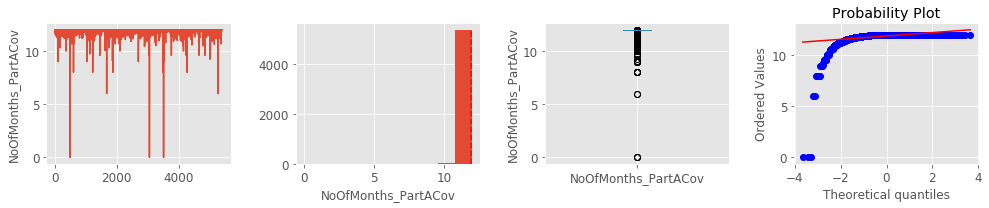

FEATURE: NoOfMonths_PartBCov


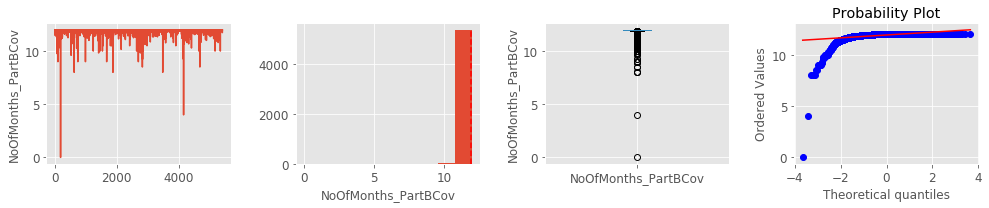

FEATURE: IPAnnualReimbursementAmt


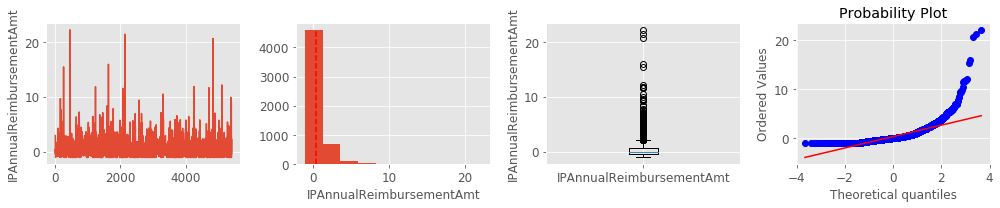

FEATURE: IPAnnualDeductibleAmt


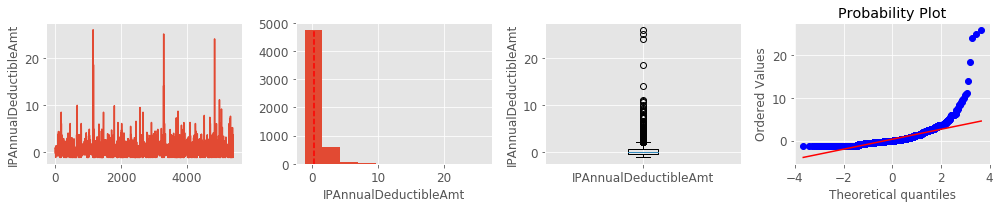

FEATURE: OPAnnualReimbursementAmt


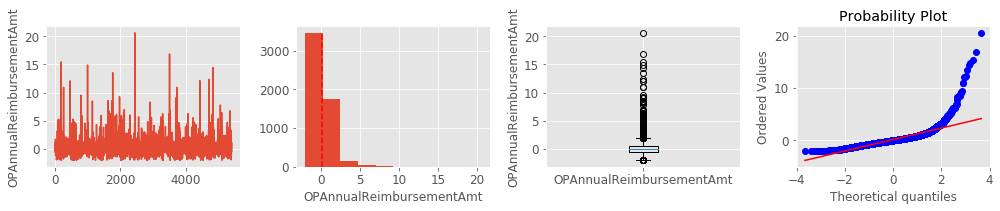

FEATURE: OPAnnualDeductibleAmt


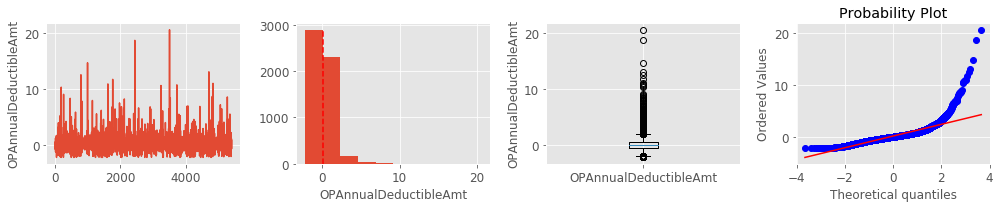

FEATURE: ChronicCond_Alzheimer


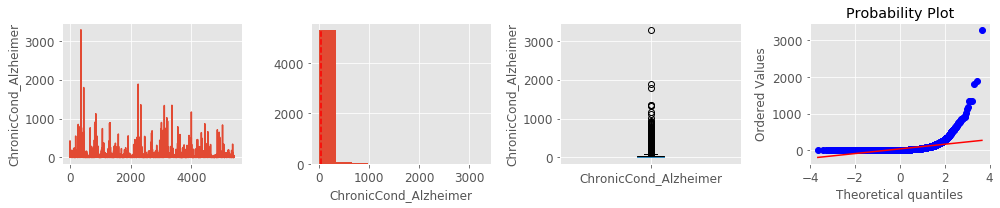

FEATURE: ChronicCond_Heartfailure


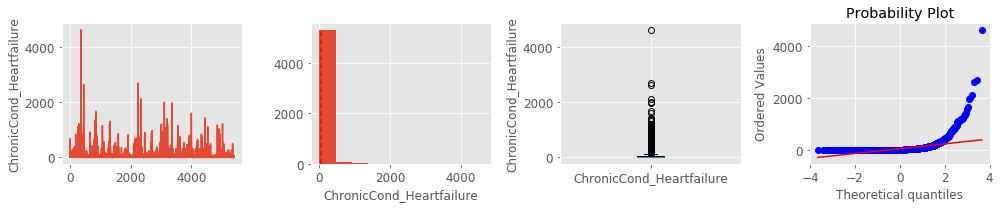

FEATURE: ChronicCond_KidneyDisease


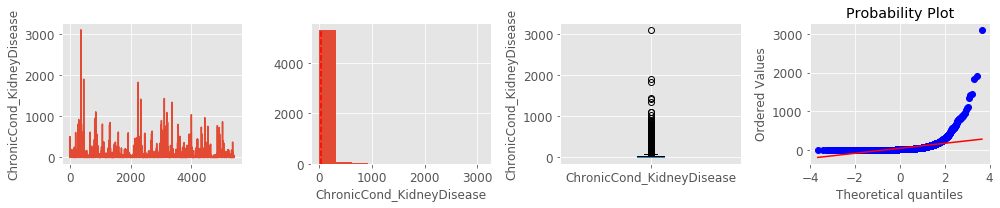

FEATURE: ChronicCond_Cancer


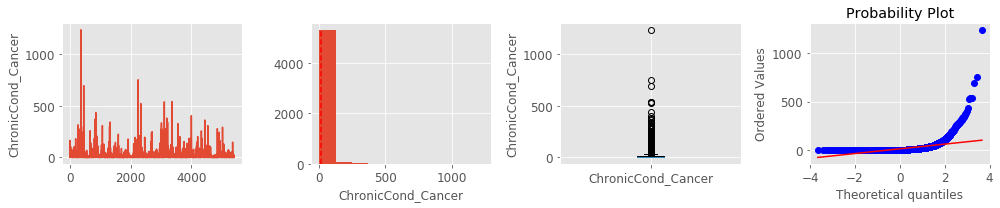

FEATURE: ChronicCond_ObstrPulmonary


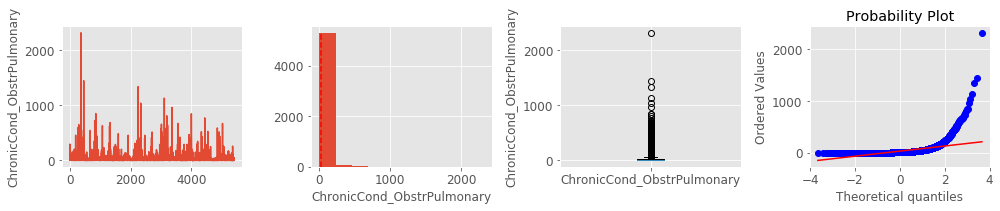

FEATURE: ChronicCond_Depression


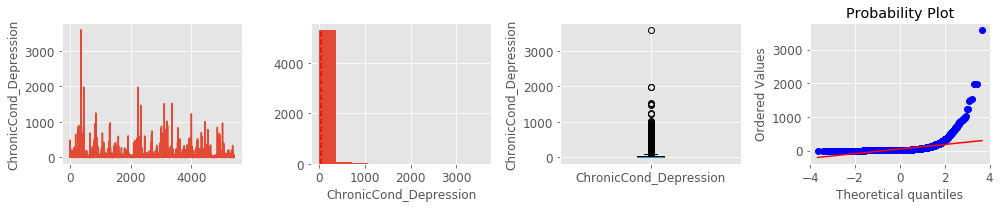

FEATURE: ChronicCond_Diabetes


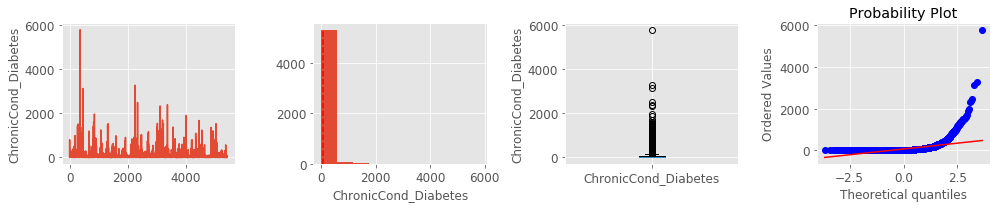

FEATURE: ChronicCond_IschemicHeart


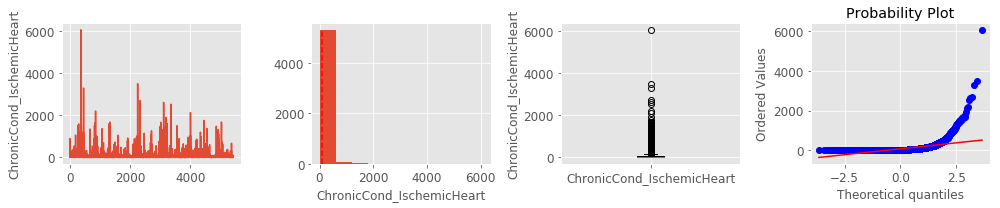

FEATURE: ChronicCond_Osteoporasis


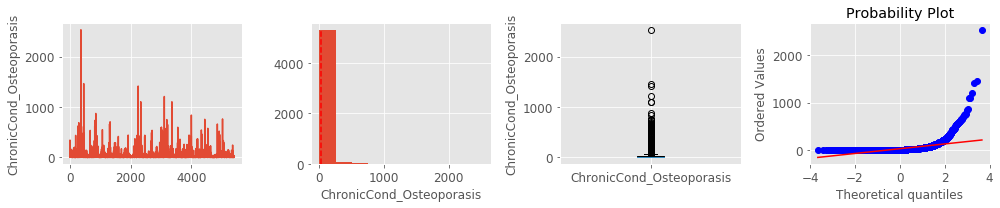

FEATURE: ChronicCond_rheumatoidarthritis


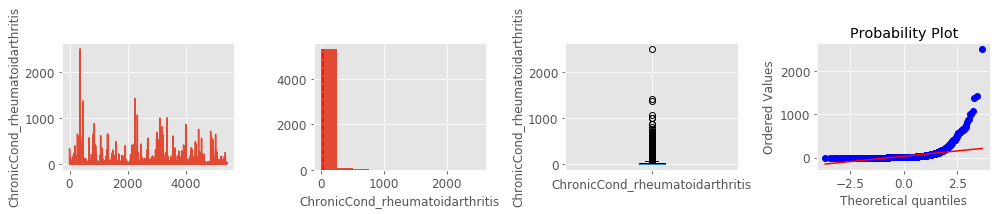

FEATURE: ChronicCond_stroke


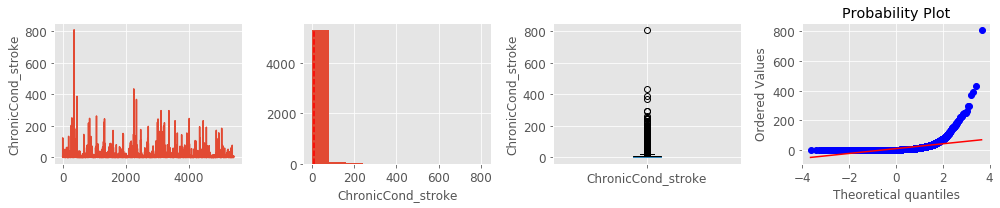

In [12]:
""" PROVIDED
Visualize the data using visualize.featureplots
"""
# Drop the provider name from the visualized data since it is not numeric
cdata = processed_data.drop(['Provider'], axis=1).astype('float64')
visualize.featureplots(cdata.values, cdata.columns)

# Decision Tree Classifiers

### Model Exploration

In [13]:
""" TODO
Split data into X (the inputs) and y (the outputs)

Hold out a subset of the data, before training and cross validation
using train_test_split, with stratify NOT equal to None, and a test_size 
fraction of .2.

For this exploratory section, the held out set of data is a validation set.
For the GridSearch section, the held out set of data is a test set.
"""
targetnames = ['NonFraud', 'Fraud']

# TODO: Separate the data into X and y



# TODO: Split data into train and test sets



In [14]:
""" TODO
Play around with the hyper-parameters. Pick your favorite model to leave with in 
your submitted report.
"""
# TODO: Create and fit the model



# TODO: Predict with the model on the validation set



# TODO: Obtain prediction probabilities for the validation set, using 
# cross_val_predict with cv=10 and method='predict_proba'



# TODO: The mean CV accuracy on the given validation data and labels, using 
# cross_val_score and cv=10
scorescv = # TODO
np.mean(scorescv)

0.926952861952862

ROC AUC: 0.8765353599580141
PRC AUC: 0.48933800740575933
PSS: 0.3176
F1 Score 0.4615


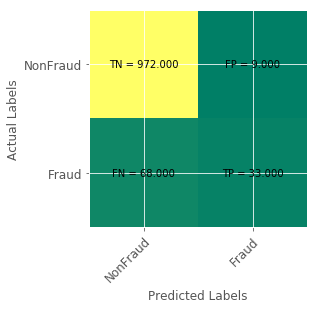

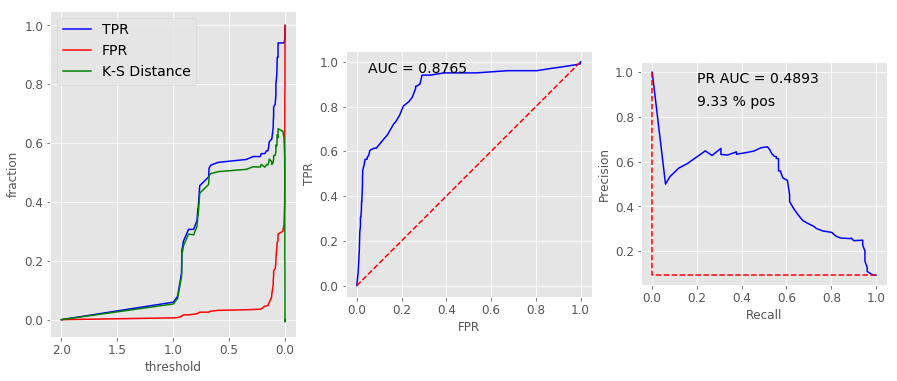

In [15]:
""" TODO
Display the confusion matrix, KS plot, ROC curve, and PR curve for the validation set
using metrics_plots.ks_roc_prc_plot

The red dashed line in the PRC is indicative of a the expected performance for a random
classifier, which would predict predict postives at the rate of occurance within the data set
"""
# TODO: Confusion Matrix



# TODO: Curves
# Note, you'll want the probability class predictions for the class label 1
# See the API page for the DecisionTreeClassifier predict_proba; proba_val[:,1]



# Obtain the PSS and F1 Score
pss_val = metrics_plots.skillScore(ytest, preds_val)
f1_val = f1_score(ytest, preds_val)
print("PSS: %.4f" % pss_val[0])
print("F1 Score %.4f" % f1_val)

In [16]:
""" TODO
Export the image of the tree model
use export_graphviz
"""



# GRID SEARCH CV

In [17]:
""" TODO
Estimated time: <10 min on mlserver
Set up and run the grid search using GridSearchCV and the following 
settings:
* The below scoring dictionary for scoring,
* refit set to 'f1' as the optimized metric
* Twenty for the number of cv folds, 
* n_jobs=3, 
* verbose=2, 
* return_train_score=True
"""
# Optimized metric
opt_metric = 'f1'
scoring = {opt_metric:opt_metric}

# Flag to re-load previous run regardless of whether the file exists
force = True
# File previous run is saved to
srchfname = "hw9_search_" + opt_metric + ".pkl"

# SETUP EXPERIMENT HYPERPARAMETERS
max_depths = [None, 200, 100, 10, 8, 6, 4]
max_leaf_nodes = [None, 10, 5, 2]

ndepths = len(max_depths)
nleaves = len(max_leaf_nodes)

# TODO: Create the dictionary of hyper-parameters to try
hyperparams = # TODO

# RUN EXPERIMENT
time0 = timelib.time()
search = None
if force or (not os.path.exists(srchfname)):
    # TODO: Create the GridSearchCV object
    search = # TODO

    # TODO: Execute the grid search by calling fit using the training data

    
    # TODO: Save the grid search object

    print("Saved %s" % srchfname)
else:
    # TODO: Re-load the grid search object
    
    print("Loaded %s" % srchfname)

time1 = timelib.time()
duration = time1 - time0
print("Elapsed Time: %.2f min" % (duration / 60))

search

Fitting 20 folds for each of 28 candidates, totalling 560 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    6.1s
[Parallel(n_jobs=3)]: Done 234 tasks      | elapsed:   15.7s


Saved hw9_search_sol_f1.pkl
Elapsed Time: 0.51 min


[Parallel(n_jobs=3)]: Done 560 out of 560 | elapsed:   30.4s finished


GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_depth': [None, 200, 100, 10, 8, 6, 4], 'max_leaf_nodes': [None, 10, 5, 2]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1': 'f1'}, verbose=2)

# RESULTS

In [18]:
""" PROVIDED
Display the head of the results for the grid search
See the cv_results_ attribute
"""
all_results = search.cv_results_
df_res = pd.DataFrame(all_results)
df_res.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,params,split0_test_f1,split1_test_f1,split2_test_f1,...,split12_train_f1,split13_train_f1,split14_train_f1,split15_train_f1,split16_train_f1,split17_train_f1,split18_train_f1,split19_train_f1,mean_train_f1,std_train_f1
0,0.248664,0.111210,0.007147,0.005911,None,None,"{'max_depth': None, 'max_leaf_nodes': None}",0.526316,0.468085,0.400000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.093955,0.045051,0.005153,0.004397,None,10,"{'max_depth': None, 'max_leaf_nodes': 10}",0.484848,0.594595,0.564103,...,0.611367,0.579805,0.646288,0.551845,0.594090,0.605965,0.602782,0.626543,0.602039,0.035570
2,0.108059,0.049499,0.006901,0.005983,None,5,"{'max_depth': None, 'max_leaf_nodes': 5}",0.173913,0.387097,0.266667,...,0.519164,0.461783,0.502693,0.440079,0.503521,0.532081,0.513181,0.530806,0.457653,0.089814


In [19]:
""" TODO
Obtain the best model from the grid search and 
fit it to the full training data
"""



DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
""" TODO
Export the image of the best model
use export_graphviz
"""



ROC AUC: 0.876232577386179
PRC AUC: 0.4899573903027781
PSS: 0.3176
F1 Score 0.4615


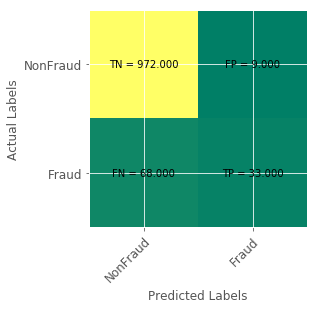

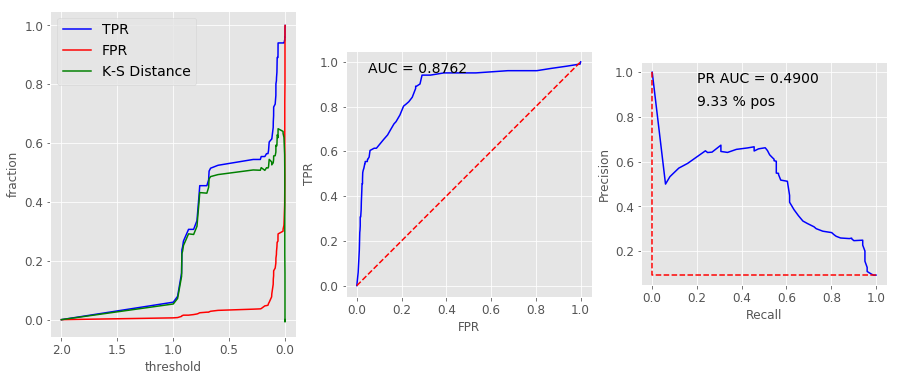

In [21]:
""" TODO
Display the confusion matrix, KS plot, ROC curve, and PR curve for the test 
set using metrics_plots.ks_roc_prc_plot

The red dashed line in the PRC is indicative of a the expected performance for
a random classifier, which would predict predict postives at the rate of 
occurance within the data set
"""
# TODO: Predict with the best model on the test set


# TODO: Obtain prediction probabilities for the test set using cross_val_predict
# 'predict_proba' as the method


# TODO: Compute mean accuracy (using cross_val_score) on the given test data and labels



# TODO: Confusion Matrix



# TODO: Curves (i.e. ROC, PRC, etc) use metrics_plots.ks_roc_prc_plot and the 
# the probabilities for the class label of 1



# Obtain the PSS and F1 Score
pss_test = metrics_plots.skillScore(ytest, preds_test)
f1_test = f1_score(ytest, preds_test)
print("PSS: %.4f" % pss_test[0])
print("F1 Score %.4f" % f1_test)

Text(0.5, 1.0, 'Model Probabilities for neg and pos examples')

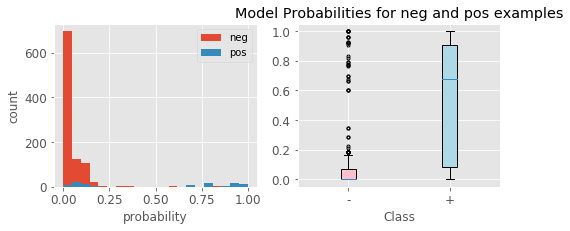

In [22]:
""" PROVIDED
Plot a histogram of the test scores from the best model.
Compare the distribution of scores for positive and negative examples
using boxplots.

Create one subplot of the distribution of all the scores, with a histogram. 
Create a second subplot comparing the distribution of the scores of the 
positive examples with the distribution of the negative examples, with boxplots.
"""
# Obtain the pos and neg indices
pos_inds = np.where(ytest)[0]
neg_inds = np.where(ytest == 0)[0]

# Separate the scores for the pos and neg examples
proba_pos = proba_test[pos_inds, 1]
proba_neg = proba_test[neg_inds, 1]

# Plot the distribution of all scores
nbins = 21
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(proba_neg, bins=nbins)
plt.hist(proba_pos, bins=nbins)
plt.xlabel('probability', fontsize=FONTSIZE)
plt.ylabel('count', fontsize=FONTSIZE)
plt.legend(['neg', 'pos'])

# Plot the boxplots of the pos and neg examples
plt.subplot(1,2,2)
boxplot = plt.boxplot([proba_neg, proba_pos], patch_artist=True, sym='.')
boxplot['boxes'][0].set_facecolor('pink')
boxplot['boxes'][1].set_facecolor('lightblue')
plt.xticks(ticks=[1, 2], labels=['-', '+'])
plt.xlabel("Class")
plt.title("Model Probabilities for neg and pos examples")

# Discussion
In 3 to 4 paragraphs, discuss and interpret the test results for the best model. Include a brief discussion of the histogram and boxplots of the scores. Compare the best model from the grid search to the one you chose in the exploration section. Additionally, embed the image of the best tree model into the notebook using:  
`<center><img src="path_to_model.png"  style="width:100%;height:100%">`  


